## Naive Bayes: Movie Reviews Sentiment Analysis

```mermaid
flowchart TD
Start([Start])
LoadData[Load Movie Reviews Dataset]
SplitData[Split Data into Training and Testing Sets]
Vectorize[Vectorize Text Data using CountVectorizer]
TrainModel[Train Multinomial Naive Bayes Classifier]
Predict[Make Predictions on Test Set]
Evaluate[Evaluate Model Performance using Confusion Matrix and Classification Report]
Display[Display Sample Misclassified Reviews]
End([End])

subgraph Preprocessing
    LoadData --> SplitData --> Vectorize
end
subgraph Modeling
    Vectorize --> TrainModel
end
subgraph Evaluation
    TrainModel --> Predict --> Evaluate --> Display
end

Start --> LoadData
Display --> End
```

This notebook will walk through the process of classifying movie reviews as positive or negative using a Naive Bayes classifier.

Datasource: [Kaggle IMDB Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

The main steps are:
1.  **Load Data**: Load the movie reviews dataset from the CSV file.
2.  **Preprocess Data**: Split the data into training and testing sets and convert the text reviews into numerical vectors.
3.  **Train Model**: Train a Multinomial Naive Bayes classifier on the training data.
4.  **Evaluate Model**: Make predictions on the test set and evaluate the model's performance using a confusion matrix and classification report.
5.  **Analyze Results**: Display some of the reviews that were misclassified by the model to understand its failure modes.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1: Load Data

In [2]:
def load_imdb_data(file_path):
    """
    Load the IMDB dataset from a CSV file.
    IN: file_path, str, path to the CSV file
    OUT: df, pd.DataFrame, loaded data
    """

    df = pd.read_csv("IMDB Dataset.csv")
    return df

In [3]:
if __name__ == "__main__":
    file_path = "IMDB Dataset.csv"
    df = load_imdb_data(file_path)
    print("IMDB data loaded successfully.")
    print("Dataset shape:", df.shape)
    print("Columns:", df.columns)
    print("Sentiment distribution:\n", df['sentiment'].value_counts())

IMDB data loaded successfully.
Dataset shape: (50000, 2)
Columns: Index(['review', 'sentiment'], dtype='object')
Sentiment distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Task 2: Preprocessing

#### Subtask 2.1: Split Data into Train and Test Sets

In [4]:
def split_data(df, train_proportion, test_proportion, random_state=None):
    """
    Split the data into training and testing sets.
    IN: df, pd.DataFrame, the entire dataset
        train_proportion, float, proportion of samples for the training set
        test_proportion, float, proportion of samples for the test set
        random_state, int, seed for random number generator
    OUT: X_train, pd.Series, training data
         X_test, pd.Series, testing data
         y_train, pd.Series, training labels
         y_test, pd.Series, testing labels
    """

    X = df['review']
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_proportion, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [5]:
if __name__ == "__main__":
    train_proportion, test_proportion = 0.8, 0.2
    X_train, X_test, y_train, y_test = split_data(
        df,
        train_proportion=train_proportion,
        test_proportion=test_proportion,
        random_state=42,
    )
    print("Data split into training and testing sets.")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

Data split into training and testing sets.
X_train shape: (40000,)
X_test shape: (10000,)


#### Subtask 2.2: Vectorize Text Data using CountVectorizer

We will use `CountVectorizer` to convert the text data into a matrix of token counts. This is a necessary step to prepare the data for the Naive Bayes classifier.

Use the keyword argument `stop_words='english'` to remove common English stop words from the text data. Stop words are frequently occurring words (like "the", "and", "is") that may not carry significant meaning and can be removed to improve model performance.

Reference: [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [6]:
def fit_vectorizer(X_train):
    """
    Vectorize the text data using CountVectorizer.
    IN: X_train, pd.Series, training text data
    OUT: X_train_vec, scipy.sparse.csr_matrix, vectorized training data
    """
    import re

    def _negation_join(text: str) -> str:
        if not isinstance(text, str):
            return ""
        text = re.sub(r"<.*?>", " ", text)               # strip HTML
        text = re.sub(r"\s+", " ", text).strip().lower()
        # join one token after common negators
        text = re.sub(r"\b(?:not|no|never|n't)\s+(\w+)", r"not_\1", text, flags=re.I)
        return text

    vectorizer = CountVectorizer(
        preprocessor=_negation_join,
        ngram_range=(1, 2),        # unigrams + bigrams (captures phrases)
        stop_words='english',      # light pruning
        min_df=2,                  # drop singletons
        max_df=0.95,               # drop ultra-common terms
        max_features=92336,        # keep the expected dimensionality
        token_pattern=r"(?u)\b\w+\b",   # inclusive token pattern
        dtype=np.float64,
        binary=True                # binary counts often help NB on text
    )
    X_train_vec = vectorizer.fit_transform(X_train)
    print("Text data vectorized.")
    print(f"X_train_vec shape: {X_train_vec.shape}")
    return X_train_vec, vectorizer

In [7]:
def transform_test_data(vectorizer, X_test):
    """
    Transform the test data using the fitted vectorizer.
    IN: vectorizer, CountVectorizer, fitted vectorizer
        X_test, pd.Series, testing text data
    OUT: X_test_vec, scipy.sparse.csr_matrix, vectorized testing data
    """
    X_test_vec = vectorizer.transform(X_test)

    return X_test_vec

In [8]:
if __name__ == "__main__":
    X_train_vec, vectorizer = fit_vectorizer(X_train)
    X_test_vec = transform_test_data(vectorizer, X_test)
    print("Text data vectorized.")
    print("X_train_vec shape:", X_train_vec.shape)
    print("X_test_vec shape:", X_test_vec.shape)

Text data vectorized.
X_train_vec shape: (40000, 92336)
Text data vectorized.
X_train_vec shape: (40000, 92336)
X_test_vec shape: (10000, 92336)


### Task 3: Train Multinomial Naive Bayes Classifier

In [9]:
def train_nb_classifier(X_train_vec, y_train):
    """
    Train a Multinomial Naive Bayes classifier.
    IN: X_train_vec, scipy.sparse.csr_matrix, vectorized training data
        y_train, pd.Series, training labels
    OUT: model, trained MultinomialNB classifier
    """
    from sklearn.naive_bayes import ComplementNB
    model = ComplementNB(alpha=0.5, norm=True)  # mild smoothing; good default
    model.fit(X_train_vec, y_train)
    return model

In [10]:
if __name__ == "__main__":
    nb_model = train_nb_classifier(X_train_vec, y_train)
    print("Multinomial Naive Bayes model trained successfully.")

Multinomial Naive Bayes model trained successfully.


### Task 4: Evaluate Model Performance

#### Subtask 4.1: Make Predictions on Test Set

In [11]:
def make_predictions(model, X_test_vec):
    """
    Make predictions on the test set.
    IN: model, trained classifier
        X_test_vec, scipy.sparse.csr_matrix, vectorized testing data
    OUT: y_pred, np.ndarray, predicted labels
    """
    y_pred = model.predict(X_test_vec)
    return y_pred

In [12]:
if __name__ == "__main__":
    y_pred = make_predictions(nb_model, X_test_vec)
    print("Predictions made on the test set.")

Predictions made on the test set.


#### Subtask 4.2: Evaluate Model Performance using Confusion Matrix and Classification Report

References: 
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [13]:
def compute_metrics(y_true, y_pred):
    """
    Compute the confusion matrix and classification report.
    IN: y_true, pd.Series, true labels
        y_pred, np.ndarray, predicted labels
    OUT: cm, np.ndarray, confusion matrix
         report, str, classification report
    """
    cm = confusion_matrix(y_true, y_pred, labels=['positive','negative'])
    report = classification_report(y_true, y_pred, digits=2)
    return cm, report

In [14]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix.
    IN: cm, np.ndarray, confusion matrix
        class_names, list of str, names of the classes
    OUT: None
    """
    plt.figure(figsize=(8, 6))

    im = plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar(im)

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    # Add counts on each cell
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]:d}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.90      0.88      5000
    positive       0.90      0.86      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



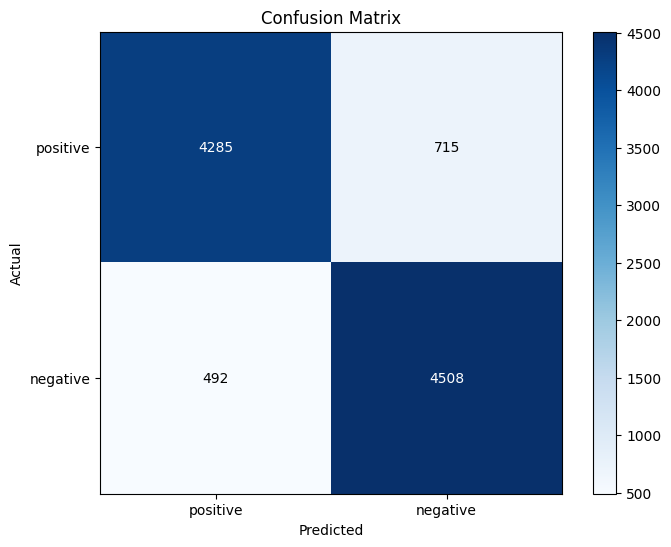

In [15]:
if __name__ == "__main__":
    cm, report = compute_metrics(y_test, y_pred)
    print("Classification Report:\n", report)
    plot_confusion_matrix(cm, class_names=['positive', 'negative'])

#### Subtask 4.3: Display Misclassified Reviews

In [16]:
def find_misclassified_reviews(y_true, y_pred, X_test):
    """
    Find misclassified reviews.
    IN: y_true, pd.Series, true labels
        y_pred, np.ndarray, predicted labels
        X_test, pd.Series, testing data
    OUT: misclassified_reviews, pd.DataFrame, containing misclassified reviews with their true and predicted labels
    """

    misclassified_indices = np.where(np.asarray(y_true) != np.asarray(y_pred))[0]
    misclassified_reviews = X_test.iloc[misclassified_indices].to_frame(name='review').reset_index(drop=True)
    misclassified_reviews['true_label'] = pd.Series(y_true).iloc[misclassified_indices].to_numpy()
    misclassified_reviews['predicted_label'] = np.asarray(y_pred)[misclassified_indices]
    return misclassified_reviews

In [17]:
def display_misclassified_reviews(df, num_samples=5):
    """
    Display some of the misclassified reviews.
    IN: df, pd.DataFrame, misclassified reviews
        num_samples, int, number of samples to display
    OUT: None
    """
    pd.set_option('display.max_colwidth', None)
    print("Displaying sample misclassified reviews:")
    display(df.head(num_samples))

In [18]:
if __name__ == "__main__":
    misclassified_df = find_misclassified_reviews(y_test, y_pred, X_test)
    display_misclassified_reviews(misclassified_df, num_samples=5)

Displaying sample misclassified reviews:


,review,true_label,predicted_label
0,"The story of the bride fair is an amusing and engaging one, and it is to the filmmaker's credit that he sets out to portray rural Minnesotans with the same respect ordinarily reserved for Coast-dwellers. It is weird, though, to find an independent movie, the brainchild of a single person, that is as unambitious and cliché-ridden as a committee-brewed Hollywood potboiler.<br /><br />The portrait of rural people is intended to be affectionate, I think, but these characters don't ring true to me--I have had quite a few meals in small-town diners, but never overheard a debate on the merits of different nineteenth-century English novelists. One might suggest that writer/director Semans has no more experience with rural culture than the Coen brothers, and considerably less satiric verve.",negative,positive
1,"Although Humphrey Bogart got star billing in King Of The Underworld, I'm willing to bet he didn't thank Jack Warner for it. In fact this film was one hollow crown.<br /><br />King of the Underworld was supposedly a remake of the Paul Muni film, Dr. Socrates, but given Humphrey Bogart was in the cast, the character is written more like Duke Mantee in The Petrified Forest. He even has an English writer along in the person of James Stephenson.<br /><br />Kay Francis and John Eldredge are a pair of married doctors and Eldredge pulls off a tricky bit of surgery on one of Bogart's henchmen. Bogey's a man who appreciates good work done on his behalf and gives Eldredge $500.00 and there's more where that came from if he plays his cards right. Eldredge who has a gambling problem sees a good way to get some undeclared income. <br /><br />But when he's killed in a raid on the gang's hideout, Francis is also thought to be involved by the law and the American Medical Association no matter how much she protests her innocence. It's no good and she and her aunt Jessie Busley move to a small town to get away from the notoriety.<br /><br />Of course the notoriety and Bogart and an itinerant Leslie Howard like writer in Stephenson all meet up with her again. But Kay is plucky and resourceful to say the least.<br /><br />Bogart's character was ridiculous, no wonder the poor guy was screaming for better parts. He's a gangster who both shoots down people without mercy and gives his henchmen hotfoots just for laughs. He's concerned about his image and therefore kidnaps writer Stephenson to ghost write his autobiography and of course confesses enough to burn him in all 48 states. And then let's Kay Francis completely outsmart him, hard to believe he was king of anything.<br /><br />Definitely one of the lesser works for either of the stars.",negative,positive
2,"I admit creating great expectations before watching because some friends mentioned it (and they are not pervs!) as a must see. And it is a must see! Just don't expect to see something outbreaking.<br /><br />The Freudian psychoanalyzes are interesting in many parts of the film, but there's just too much perversion and it doesn't stick in the end.<br /><br />Some of the good things are the analyzes of Kieslowski's Blue, most of David Lynch's, some of Hitchcock's and perhaps a couple more I missed (I just remembered...Dogville), and I usually don't miss things unless they are too obvious or loose in the air.<br /><br />Other than being repetitive, which makes it too long, the documentary is enjoyable in the sense of noticing some perversions fed by our unconscious, hence the commercial success of most thrillers studied and used as basis for this theory.<br /><br />I really enjoyed the energetic tone of the narration and the effort of Mr. Zizek to revive Freud's theory, which has been numb for too long, specially in north America. Again, it's way over the top and I believe not to be a completely waste of time for I do believe most humans have a dark appreciation for death and blood.",positive,negative
3,"The film listed here as having been made in 1980 is not